# Author Identification using NLP and Machine Learning

This notebook implements an author identification system using TF-IDF features and classification models.


In [ ]:
# Import necessary libraries
import os  # For file and directory operations
import re  # For text pattern matching and cleaning
from pathlib import Path  # For path operations
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical visualizations
from sklearn.model_selection import train_test_split  # To split data into train and test sets
from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text to TF-IDF features
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier
from sklearn.svm import LinearSVC  # Support Vector Machine classifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report  # Evaluation metrics
from nltk.corpus import stopwords  # Common words to remove from text
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages


In [15]:
# Try to import nltk library (used for natural language processing)
try:
    import nltk
except:
    pass


## Part A: Data Loading and Preprocessing


In [ ]:
# Define the directory containing text files (relative path from notebook location)
DATA_DIR = Path("../data/raw_texts")

# Print directory information for debugging
print("DATA_DIR:", DATA_DIR.resolve())
print("Exists:", DATA_DIR.exists())

# Initialize lists to store texts and their authors
texts = []
authors = []

# Loop through each author folder in the directory
for author_folder in sorted(os.listdir(DATA_DIR), key=lambda x: int(x)):
    author_path = DATA_DIR / author_folder
    # Check if it's a directory
    if author_path.is_dir():
        # Loop through each text file in the author's folder
        for filename in sorted(os.listdir(author_path), key=lambda x: int(x.split('.')[0])): 
            file_path = author_path / filename
            try:
                # Read the text file
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()
                    texts.append(text)  # Store the text content
                    authors.append(f'Author_{author_folder}')  # Store the author label
            except:
                continue  # Skip files that can't be read

# Print summary statistics about the loaded data
print(f"Total number of texts: {len(texts)}")
print(f"Total number of authors: {len(set(authors))}")
print(f"Number of samples per author: {len(texts) // len(set(authors))}")


Total number of texts: 1500
Total number of authors: 30
Number of samples per author: 50


In [17]:
# Load English stop words (common words like 'the', 'a', 'is' that we want to remove)
try:
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set()

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)  # Remove all non-alphabetic characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = text.strip()  # Remove leading/trailing whitespace
    
    # Split into words and filter out stop words and very short words
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 1] 
    return ' '.join(words)  # Join words back into a string

# Apply preprocessing to all texts
processed_texts = [preprocess_text(text) for text in texts]
print(f"\nSample processed text (first 200 characters):\n{processed_texts[0][:200]}")

# Convert authors list to numpy array (this will be our target variable)
y = np.array(authors)



Sample processed text (first 200 characters):
doubt edinburgh huge tourist attraction within united kingdom internationally much see scotland capital arguably biggest gateway biggest draw capitals always lucky never met anyone choice travelled au


## Part B: Feature Engineering (Word and Character TF-IDF)


In [18]:
# Create TF-IDF vector for word-level features
vectorizer_word = TfidfVectorizer(
    analyzer="word",  # Analyze at word level
    max_features=5000,  # Keep top 5000 most important features
    ngram_range=(1, 2),  # Use single words and word pairs (bigrams)
    min_df=2,  # Word must appear in at least 2 documents
    max_df=0.95  # Word must appear in less than 95% of documents
)
# Convert texts to TF-IDF feature matrix
X_word = vectorizer_word.fit_transform(processed_texts)
print(f"\nFeature matrix shape (Word TF-IDF): {X_word.shape}")



Feature matrix shape (Word TF-IDF): (1500, 5000)


In [19]:
# Create TF-IDF vectorizer for character-level features
vectorizer_char = TfidfVectorizer(
    analyzer="char",  # Analyze at character level
    ngram_range=(3, 5),  # Use character sequences of length 3 to 5
    max_features=10000,  # Keep top 10000 most important features
    min_df=5  # Character sequence must appear in at least 5 documents
)
# Convert texts to TF-IDF feature matrix
X_char = vectorizer_char.fit_transform(processed_texts)
print(f"Feature matrix shape (Char TF-IDF): {X_char.shape}")


Feature matrix shape (Char TF-IDF): (1500, 10000)


## Part C: Modeling and Evaluation


In [20]:
# Split word features into training and testing sets (80% train, 20% test)
X_train_word, X_test_word, y_train, y_test = train_test_split(
    X_word, y, test_size=0.2, random_state=42, stratify=y  # stratify ensures balanced author distribution
)
# Split character features into training and testing sets (same split as word features)
X_train_char, X_test_char, _, _ = train_test_split(
    X_char, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set size: {X_train_word.shape[0]}, Test set size: {X_test_word.shape[0]}")



Train set size: 1200, Test set size: 300


In [21]:
# Function to train a model and evaluate its performance
def train_and_evaluate(model, X_train, X_test, y_train, y_test, feature_type, model_name):
    # Train the model on training data
    model.fit(X_train, y_train)
    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)  # Weighted F1 score
    report = classification_report(y_test, y_pred, zero_division=0)  # Detailed classification report
    cm = confusion_matrix(y_test, y_pred)  # Confusion matrix
    
    # Print results
    print("\n" + "=" * 60)
    print(f"{model_name} RESULTS ({feature_type} TF-IDF)")
    print("=" * 60)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Return results as a dictionary
    return {'Model': model_name, 'Feature': feature_type, 'Accuracy': accuracy, 'F1-Score': f1, 'Pred': y_pred, 'CM': cm}


In [22]:
# Initialize list to store all results
results = []
# Create Naive Bayes model with smoothing parameter
mnb_model = MultinomialNB(alpha=1.0)
# Create Support Vector Machine model
svm_model = LinearSVC(random_state=42, max_iter=2000)

# Train and evaluate Naive Bayes with word features
results.append(train_and_evaluate(
    mnb_model, X_train_word, X_test_word, y_train, y_test, "Word", "MNB (Naive Bayes)"
))

# Train and evaluate SVM with word features
results.append(train_and_evaluate(
    svm_model, X_train_word, X_test_word, y_train, y_test, "Word", "LinearSVC (SVM)"
))



MNB (Naive Bayes) RESULTS (Word TF-IDF)
Accuracy: 0.7833
F1-Score (weighted): 0.7774

Classification Report:
              precision    recall  f1-score   support

    Author_1       0.88      0.70      0.78        10
   Author_10       0.48      1.00      0.65        10
   Author_11       0.88      0.70      0.78        10
   Author_12       0.43      1.00      0.61        10
   Author_13       0.83      1.00      0.91        10
   Author_14       1.00      0.40      0.57        10
   Author_15       1.00      0.80      0.89        10
   Author_16       1.00      0.60      0.75        10
   Author_17       1.00      0.90      0.95        10
   Author_18       1.00      0.70      0.82        10
   Author_19       0.71      1.00      0.83        10
    Author_2       0.62      1.00      0.77        10
   Author_20       0.67      1.00      0.80        10
   Author_21       1.00      0.60      0.75        10
   Author_22       0.71      1.00      0.83        10
   Author_23       0.91  

In [23]:
# Train and evaluate Naive Bayes with character features
results.append(train_and_evaluate(
    mnb_model, X_train_char, X_test_char, y_train, y_test, "Character", "MNB (Naive Bayes)"
))

# Train and evaluate SVM with character features
results.append(train_and_evaluate(
    svm_model, X_train_char, X_test_char, y_train, y_test, "Character", "LinearSVC (SVM)"
))



MNB (Naive Bayes) RESULTS (Character TF-IDF)
Accuracy: 0.7367
F1-Score (weighted): 0.7160

Classification Report:
              precision    recall  f1-score   support

    Author_1       1.00      0.20      0.33        10
   Author_10       0.42      1.00      0.59        10
   Author_11       0.83      0.50      0.62        10
   Author_12       0.50      0.90      0.64        10
   Author_13       0.77      1.00      0.87        10
   Author_14       1.00      0.40      0.57        10
   Author_15       0.89      0.80      0.84        10
   Author_16       0.88      0.70      0.78        10
   Author_17       0.90      0.90      0.90        10
   Author_18       1.00      0.80      0.89        10
   Author_19       0.71      1.00      0.83        10
    Author_2       0.56      1.00      0.71        10
   Author_20       0.59      1.00      0.74        10
   Author_21       1.00      0.40      0.57        10
   Author_22       0.71      1.00      0.83        10
   Author_23       0

## Part D: Analysis and Visualization



ALL MODEL AND FEATURE COMBINATIONS COMPARISON
            Model   Feature  Accuracy  F1-Score
  LinearSVC (SVM) Character  0.910000  0.908356
  LinearSVC (SVM)      Word  0.906667  0.904641
MNB (Naive Bayes)      Word  0.783333  0.777423
MNB (Naive Bayes) Character  0.736667  0.716032


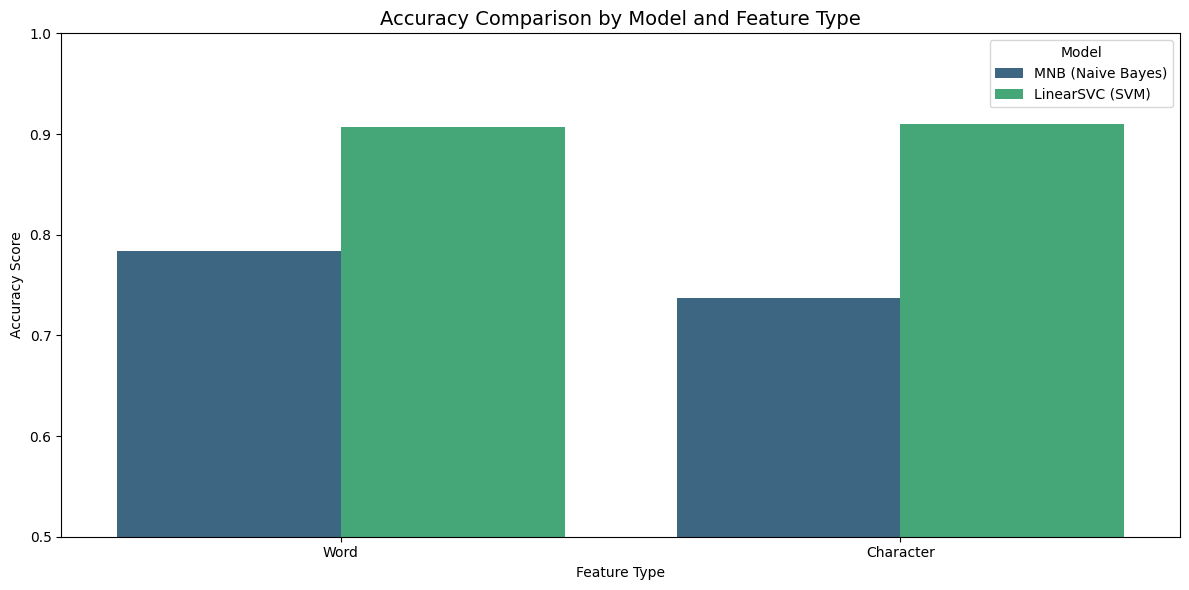

In [24]:
# Create a dataframe with results for comparison
comparison_df = pd.DataFrame(results)[['Model', 'Feature', 'Accuracy', 'F1-Score']]

# Print comparison table sorted by accuracy
print("\n" + "=" * 60)
print("ALL MODEL AND FEATURE COMBINATIONS COMPARISON")
print("=" * 60)
print(comparison_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

# Create a bar plot comparing accuracy across models and feature types
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Accuracy', hue='Model', data=comparison_df, palette='viridis')
plt.title('Accuracy Comparison by Model and Feature Type', fontsize=14)
plt.ylim(0.5, 1.0)  # Set y-axis range
plt.ylabel('Accuracy Score')
plt.xlabel('Feature Type')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


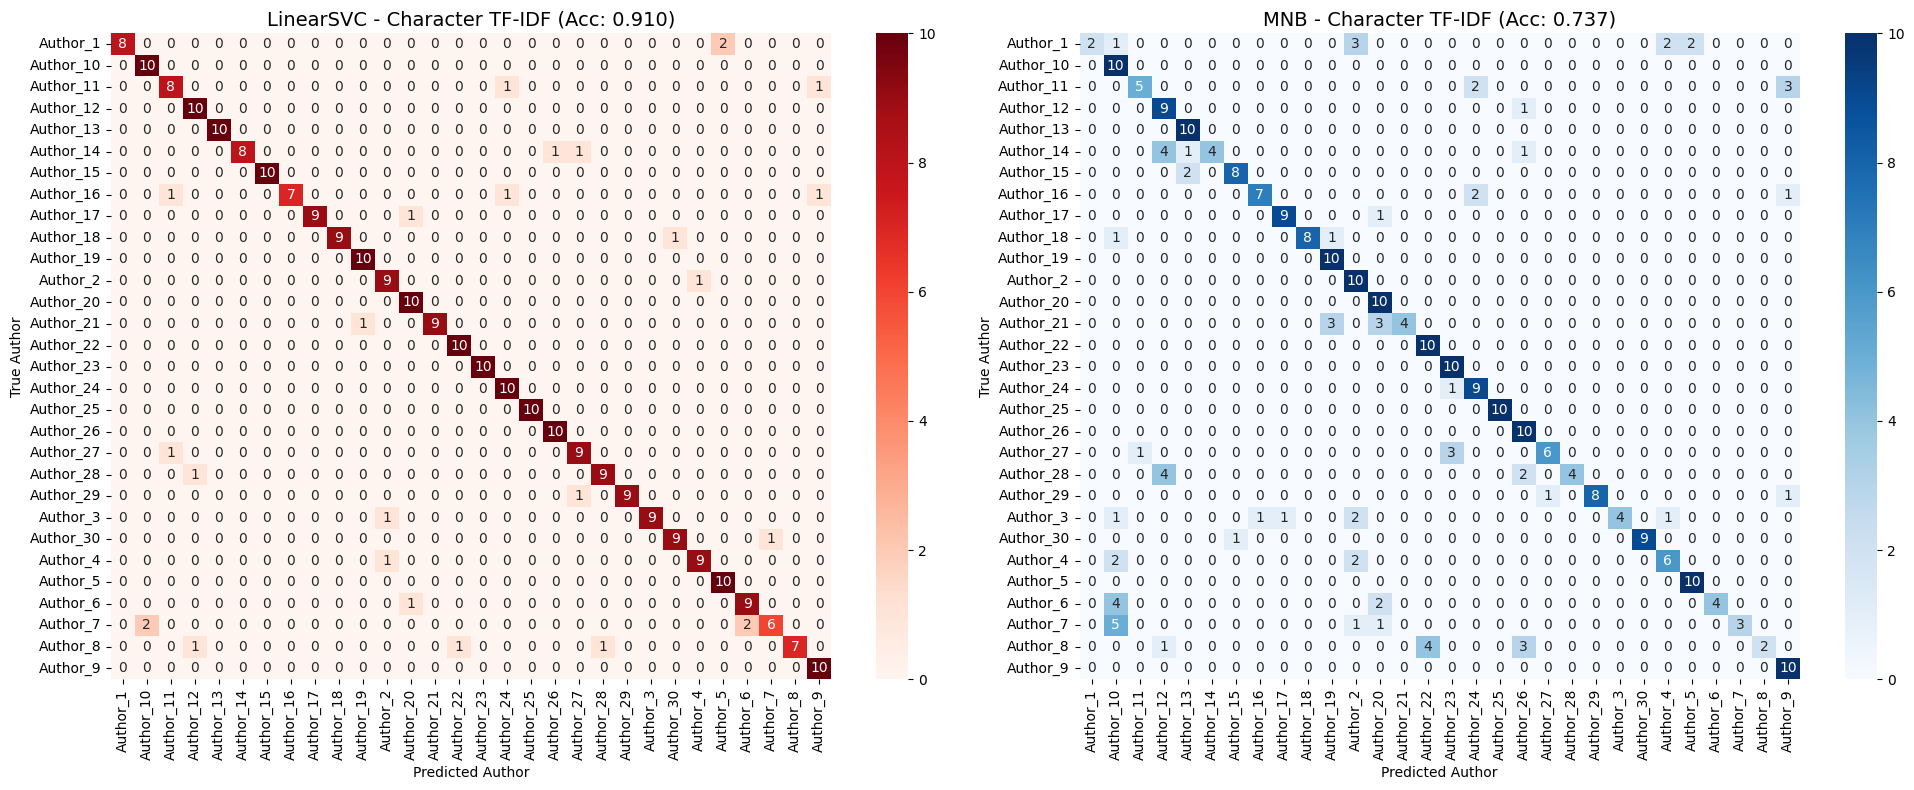

In [25]:
# Get the best results for SVM and Naive Bayes with character features
best_svm_result = comparison_df.loc[(comparison_df['Model'] == 'LinearSVC (SVM)') & (comparison_df['Feature'] == 'Character')].iloc[0]
best_mnb_result = comparison_df.loc[(comparison_df['Model'] == 'MNB (Naive Bayes)') & (comparison_df['Feature'] == 'Character')].iloc[0]

# Extract confusion matrices for character-based models
cm_svm_char = [r['CM'] for r in results if r['Model'] == 'LinearSVC (SVM)' and r['Feature'] == 'Character'][0]
cm_mnb_char = [r['CM'] for r in results if r['Model'] == 'MNB (Naive Bayes)' and r['Feature'] == 'Character'][0]

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
author_labels = sorted(set(y_test))  # Get sorted list of author labels

# Plot SVM confusion matrix
sns.heatmap(cm_svm_char, annot=True, fmt='d', cmap='Reds', ax=axes[0], 
            xticklabels=author_labels, yticklabels=author_labels)
axes[0].set_title(f"LinearSVC - Character TF-IDF (Acc: {best_svm_result['Accuracy']:.3f})", fontsize=14)
axes[0].set_xlabel('Predicted Author')
axes[0].set_ylabel('True Author')

# Plot Naive Bayes confusion matrix
sns.heatmap(cm_mnb_char, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=author_labels, yticklabels=author_labels)
axes[1].set_title(f"MNB - Character TF-IDF (Acc: {best_mnb_result['Accuracy']:.3f})", fontsize=14)
axes[1].set_xlabel('Predicted Author')
axes[1].set_ylabel('True Author')

plt.tight_layout()
plt.show()


In [26]:
# Train Naive Bayes model for word feature analysis
mnb_analysis_model_word = MultinomialNB(alpha=1.0)
mnb_analysis_model_word.fit(X_train_word, y_train)

# Find and display top 10 most indicative words for each author (Naive Bayes)
print("\n" + "=" * 60)
print("TOP 10 INDICATIVE WORDS (A: MNB - Word TF-IDF)")
print("=" * 60)

feature_names_word = vectorizer_word.get_feature_names_out()
for i, author in enumerate(mnb_analysis_model_word.classes_[:5]): 
    class_idx = np.where(mnb_analysis_model_word.classes_ == author)[0][0]
    log_probs = mnb_analysis_model_word.feature_log_prob_[class_idx]  # Get log probabilities for this author
    top_indices = np.argsort(log_probs)[-10:][::-1]  # Get indices of top 10 features
    top_words = [feature_names_word[idx] for idx in top_indices]
    print(f"\n{author}: {', '.join(top_words)}")


# Train SVM model for word feature analysis
svm_analysis_model_word = LinearSVC(random_state=42, max_iter=2000)
svm_analysis_model_word.fit(X_train_word, y_train)

# Find and display top 10 most indicative words for each author (SVM)
print("\n" + "=" * 60)
print("TOP 10 INDICATIVE WORDS (B: LinearSVC - Word TF-IDF)")
print("=" * 60)

feature_names_word = vectorizer_word.get_feature_names_out()
for i, author in enumerate(svm_analysis_model_word.classes_[:5]): 
    class_idx = np.where(svm_analysis_model_word.classes_ == author)[0][0]
    coef = svm_analysis_model_word.coef_[class_idx]  # Get coefficients for this author
    top_indices = np.argsort(coef)[-10:][::-1]  # Get indices of top 10 features
    top_features = [feature_names_word[idx] for idx in top_indices]
    top_scores = [coef[idx] for idx in top_indices]

    print(f"\n{author} (Word N-grams):")
    for feat, score in zip(top_features, top_scores):
        print(f"  {feat}: {score:.4f}")


# Train Naive Bayes model for character feature analysis
mnb_analysis_model_char = MultinomialNB(alpha=1.0)
mnb_analysis_model_char.fit(X_train_char, y_train)

# Find and display top 10 most indicative character features for each author (Naive Bayes)
print("\n" + "=" * 60)
print("TOP 10 INDICATIVE FEATURES (C: MNB - Character TF-IDF)")
print("=" * 60)

feature_names_char = vectorizer_char.get_feature_names_out()
for i, author in enumerate(mnb_analysis_model_char.classes_[:5]): 
    class_idx = np.where(mnb_analysis_model_char.classes_ == author)[0][0]
    log_probs = mnb_analysis_model_char.feature_log_prob_[class_idx]  # Get log probabilities for this author
    top_indices = np.argsort(log_probs)[-10:][::-1]  # Get indices of top 10 features
    top_features = [feature_names_char[idx] for idx in top_indices]
    print(f"\n{author} (Character N-grams): {', '.join(top_features)}")


# Train SVM model for character feature analysis
svm_analysis_model_char = LinearSVC(random_state=42, max_iter=2000)
svm_analysis_model_char.fit(X_train_char, y_train)

# Find and display top 10 most indicative character features for each author (SVM)
print("\n" + "=" * 60)
print("TOP 10 INDICATIVE FEATURES (D: LinearSVC - Character TF-IDF)")
print("=" * 60)

feature_names_char = vectorizer_char.get_feature_names_out()
for i, author in enumerate(svm_analysis_model_char.classes_[:5]): 
    class_idx = np.where(svm_analysis_model_char.classes_ == author)[0][0]
    coef = svm_analysis_model_char.coef_[class_idx]  # Get coefficients for this author
    top_indices = np.argsort(coef)[-10:][::-1]  # Get indices of top 10 features
    top_features = [feature_names_char[idx] for idx in top_indices]
    top_scores = [coef[idx] for idx in top_indices]

    print(f"\n{author} (Character N-grams):")
    for feat, score in zip(top_features, top_scores):
        print(f"  {feat}: {score:.4f}")



TOP 10 INDICATIVE WORDS (A: MNB - Word TF-IDF)

Author_1: edinburgh, brown, tax, scottish, scotland, people, would, labour, gordon, salmond

Author_10: brown, mr, labour, prime minister, minister, prime, gordon, gordon brown, mr brown, cameron

Author_11: cancer, women, patients, risk, said, dr, heart, disease, per cent, cent

Author_12: liverpool, united, league, chelsea, ferguson, goal, though, season, gerrard, game

Author_13: baseball, season, game, series, mets, team, sox, yankees, fans, players

TOP 10 INDICATIVE WORDS (B: LinearSVC - Word TF-IDF)

Author_1 (Word N-grams):
  edinburgh: 1.4783
  christmas: 0.9993
  brown: 0.8692
  charities: 0.7434
  pound: 0.6795
  scottish: 0.6564
  shall: 0.6095
  politicians: 0.5881
  people: 0.5866
  tax: 0.5574

Author_10 (Word N-grams):
  prime minister: 1.2922
  prime: 1.1373
  minister: 1.0773
  cabinet: 0.9831
  labour: 0.8301
  voters: 0.7178
  conservatives: 0.7085
  gordon: 0.6966
  gordon brown: 0.6778
  torture: 0.6728

Author_11 (